# Урок 6. Градиентный бустинг

In [1]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np

In [2]:
from sklearn.datasets import load_diabetes

In [3]:
X, y = load_diabetes(return_X_y=True)

In [4]:
X.shape

(442, 10)

In [5]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

Напишем функцию, реализующую предсказание в градиентном бустинге.

In [6]:
def gb_predict(X, trees_list, coef_list, eta):
    return np.array([sum([eta*coef*alg.predict([x])[0] for alg, coef in zip(trees_list,coef_list)]) for x in X])


В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функицию.

In [7]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [8]:
def deriv(y, z):
    return 2*(y - z)

Реализуем функцию обучения градиентного бустинга.

In [9]:
import random

def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta, sgb=False):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            if not sgb:
                # Получим ответы на текущей композиции
                pred = gb_predict(X_train, trees, coefs, eta)
            
                # алгоритмы начиная со второго обучаем на сдвиг
                tree.fit(X_train, deriv(y_train, pred))
            else:
                X_sub = np.array(zip(X_train,y_train))
#                 X_train_sub, y_train_sub = [[xx], [yy] for xx, yy in zip(X_train,y_train)]
                X_train_sub = random.sample(X, X.shape[0])
                # Получим ответы на текущей композиции
#                 pred = gb_predict(X_train_sub, trees, coefs, eta)
            
                # алгоритмы начиная со второго обучаем на сдвиг
#                 tree.fit(X_train, deriv(y_train_, pred))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

Теперь обучим несколько моделей с разными параметрами и исследуем их поведение.

In [10]:
# Число деревьев в ансамбле
n_trees = 10

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 1

# %%time
trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta, sgb=False)

In [11]:
coefs

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [12]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

In [13]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 1 на тренировочной выборке: 2683.675740289325
Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 1 на тестовой выборке: 8564.368793726737


Построим графики зависимости ошибки на обучающей и тестовой выборках от числа итераций.

In [14]:
import matplotlib.pyplot as plt

In [15]:
def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

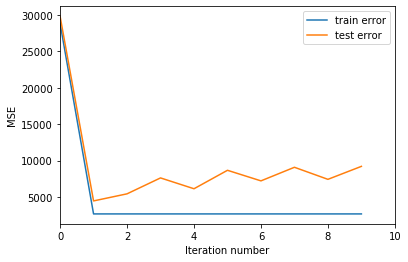

In [16]:
get_error_plot(n_trees, train_errors, test_errors)

Такой результат не является удовлетворительным

Увеличим число деревьев.

In [17]:
%%time
n_trees = 100
coefs = [1] * n_trees

# %%time
trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

Wall time: 2min 32s


In [18]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 100 деревьев глубиной 3     с шагом 1 на тренировочной выборке: 2683.675740289324
Ошибка алгоритма из 100 деревьев глубиной 3     с шагом 1 на тестовой выборке: 12189.517485985503


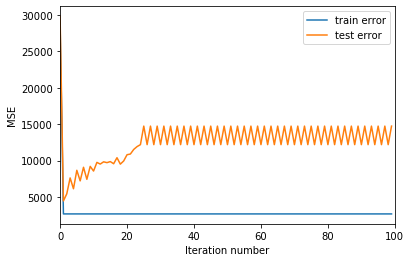

In [19]:
get_error_plot(n_trees, train_errors, test_errors)

Теперь попробуем уменьшить шаг.

In [20]:
%%time
eta = 0.1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

Wall time: 2min 27s


In [21]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 100 деревьев глубиной 3     с шагом 0.1 на тренировочной выборке: 319.26650103933156
Ошибка алгоритма из 100 деревьев глубиной 3     с шагом 0.1 на тестовой выборке: 3771.7603067852765


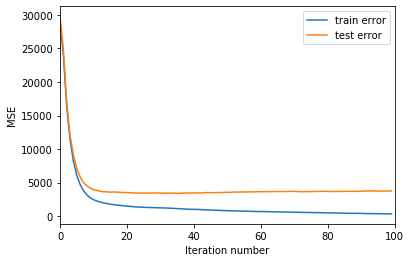

In [22]:
get_error_plot(n_trees, train_errors, test_errors)

Видим, что качество обучения улучшается.

Уменьшим шаг до 0.01.

In [23]:
%%time
eta = 0.01

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

Wall time: 2min 27s


In [24]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 100 деревьев глубиной 3     с шагом 0.01 на тренировочной выборке: 2503.006256446352
Ошибка алгоритма из 100 деревьев глубиной 3     с шагом 0.01 на тестовой выборке: 3887.226018139677


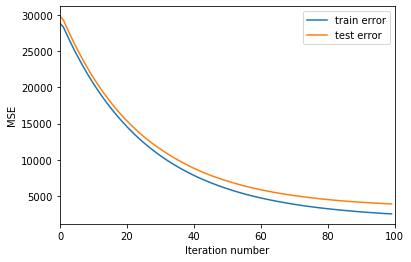

In [25]:
get_error_plot(n_trees, train_errors, test_errors)

При таком размере шага алгоритм сходится, но ему для достижения удовлетворительных показателей требуется большее количество итераций.

Вернемся к шагу 0.1 и попробуем увеличить глубину деревьев

In [26]:
%%time
eta = 0.1
max_depth = 5

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

Wall time: 2min 29s


In [27]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 100 деревьев глубиной 5     с шагом 0.1 на тренировочной выборке: 2.565277075316551
Ошибка алгоритма из 100 деревьев глубиной 5     с шагом 0.1 на тестовой выборке: 3983.0576777171023


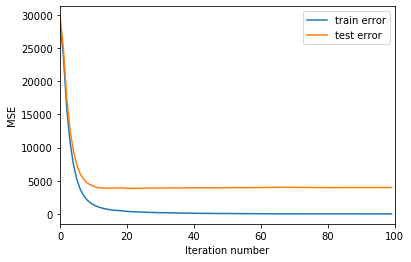

In [28]:
get_error_plot(n_trees, train_errors, test_errors)

## AdaBoost

In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_breast_cancer

In [30]:
X, y = load_breast_cancer(return_X_y=True)

Разделим выборку на обучающую и тестовую

In [31]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

Реализуем функцию подсчета ошибки

In [32]:
def get_error(pred, y):
    return sum(pred != y) / len(y)

И сам алгоритм

In [33]:
def adaboost(X, y, N):

    # Размер выборки
    n_objects = len(X)

    # Запишем количество классов в переменную
    n_classes = len(np.unique((y)))

    # Начальные веса деревьев
    w = np.ones(n_objects) / n_objects

    # Деревья с весами будем записывать в список
    models = []

    for n in range(N):
        # Зададим дерево и обучим его
        clf = DecisionTreeClassifier(max_depth=1)
        clf.fit(X, y, sample_weight=w)

        predictions = clf.predict(X)
        e = get_error(predictions, y)
        # отбросим дерево, если его ошибка больше 0.5
        # Запишем условие в общем виде (применимо к небинарным классификаторам)
        if e >= 1 - 1/n_classes: 
            break

        # Вычислим вес для дерева
        alpha = 0.5 * np.log((1 - e) / e)

        # Найдем индексы правильно классифицированных элементов
        match = predictions == y

        # Увеличим веса для неправильно классифицированных элементов
        w[~match] *= np.exp(alpha)

        # Нормализуем веса
        w /= w.sum()

        # Добавим дерево с весом в список
        models.append((alpha, clf))
    
    return models

Обучим алгоритм из 50 деревьев

In [34]:
N = 50

models = adaboost(X_train, y_train, N)

Теперь осуществим предсказание

In [35]:
def predict(X, models):
    
    n_classes = 2
    n_objects = len(X)
    
    # вначале обозначим предсказание нулевым массивом
    y_pred = np.zeros((n_objects, n_classes))
    
    for alpha, clf in models:
        prediction = clf.predict(X)
        # Для каждого предсказания будем прибавлять alpha к
        # элементу с индексом предсказанного класса
        y_pred[range(n_objects), prediction] += alpha
    
    # выберем индексы с максимальными суммарными весами -
    # получим предсказанные алгоритмом классы
    y_pred = np.argmax(y_pred, axis=1)
    
    return y_pred

print(f'Точность алгоритма на обучающей выборке: {(1 - get_error(predict(X_train, models), y_train)) * 100:.3f}')

Точность алгоритма на обучающей выборке: 99.296


In [36]:
print(f'Точность алгоритма на тестовой выборке: {(1 - get_error(predict(X_test, models), y_test)) * 100:.3f}')

Точность алгоритма на тестовой выборке: 93.706


Построим графики зависимости ошибки от количества базовых алгоритмов в ансамбле.

In [37]:
train_errors = []
test_errors = []

for n in range(1, 31):
    mods = adaboost(X_train, y_train, n)
    train_errors.append(get_error(predict(X_train, mods), y_train))
    test_errors.append(get_error(predict(X_test, mods), y_test))

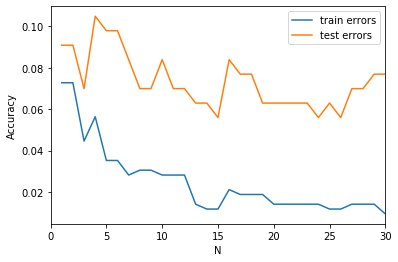

In [38]:
x = list(range(1, 31))

plt.xlim(0, 30)
plt.plot(x, train_errors, label='train errors')
plt.plot(x, test_errors, label='test errors')
plt.xlabel('N')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')

Для реализованной модели построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

Wall time: 17.9 s


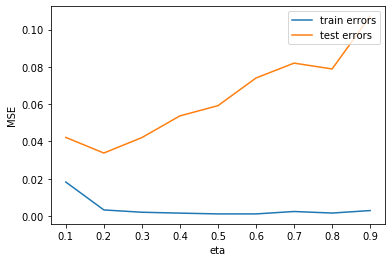

In [39]:
%%time

etas = [x*0.1 for x in range(1, 10)]
MSEs_train = []
MSEs_test = []

for eta in etas:
    max_depth = 3
    n_trees = 10

    trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

    train_prediction = gb_predict(X_train, trees, coefs, eta)
    MSEs_train.append(mean_squared_error(y_train, train_prediction))

    test_prediction = gb_predict(X_test, trees, coefs, eta)
    MSEs_test.append(mean_squared_error(y_test, test_prediction))

plt.plot(etas, MSEs_train, label='train errors')
plt.plot(etas, MSEs_test, label='test errors')
plt.xlabel('eta')
plt.ylabel('MSE')
plt.legend(loc='upper right')                                   

Wall time: 17.7 s


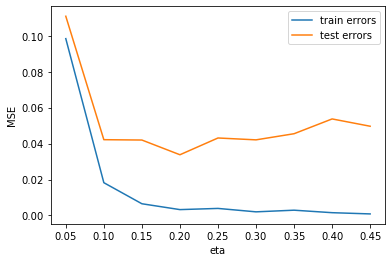

In [45]:
%%time

etas = [x*0.05 for x in range(1, 10)]
MSEs_train = []
MSEs_test = []

for eta in etas:
    max_depth = 3
    n_trees = 10

    trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

    train_prediction = gb_predict(X_train, trees, coefs, eta)
    MSEs_train.append(mean_squared_error(y_train, train_prediction))

    test_prediction = gb_predict(X_test, trees, coefs, eta)
    MSEs_test.append(mean_squared_error(y_test, test_prediction))

plt.plot(etas, MSEs_train, label='train errors')
plt.plot(etas, MSEs_test, label='test errors')
plt.xlabel('eta')
plt.ylabel('MSE')
plt.legend(loc='upper right')                                   

Wall time: 26.4 s


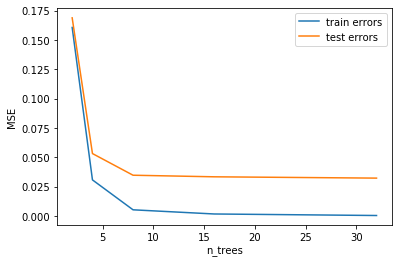

In [46]:
%%time

# etas = [0.5 + x*0.01 for x in range(1, 10)]
n_trees_arr = [2**x for x in range(1,6)]
MSEs_train = []
MSEs_test = []
eta = 0.2

for n_trees in n_trees_arr:
    max_depth = 3
#     n_trees = 10

    trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

    train_prediction = gb_predict(X_train, trees, coefs, eta)
    MSEs_train.append(mean_squared_error(y_train, train_prediction))

    test_prediction = gb_predict(X_test, trees, coefs, eta)
    MSEs_test.append(mean_squared_error(y_test, test_prediction))

plt.plot(n_trees_arr, MSEs_train, label='train errors')
plt.plot(n_trees_arr, MSEs_test, label='test errors')
plt.xlabel('n_trees')
plt.ylabel('MSE')
plt.legend(loc='upper right')                                   

Wall time: 5.77 s


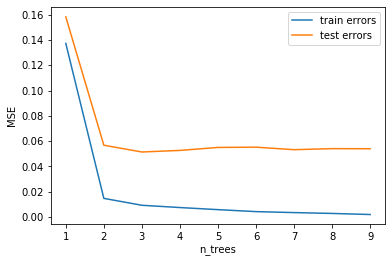

In [42]:
%%time

# etas = [0.5 + x*0.01 for x in range(1, 10)]
n_trees_arr = [x for x in range(1,10)]
MSEs_train = []
MSEs_test = []
eta = 0.2

for n_trees in n_trees_arr:
    max_depth = 3
#     n_trees = 10

    trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

    train_prediction = gb_predict(X_train, trees, coefs, eta)
    MSEs_train.append(mean_squared_error(y_train, train_prediction))

    test_prediction = gb_predict(X_test, trees, coefs, eta)
    MSEs_test.append(mean_squared_error(y_test, test_prediction))

plt.plot(n_trees_arr, MSEs_train, label='train errors')
plt.plot(n_trees_arr, MSEs_test, label='test errors')
plt.xlabel('n_trees')
plt.ylabel('MSE')
plt.legend(loc='upper right')                                   

Wall time: 40 s


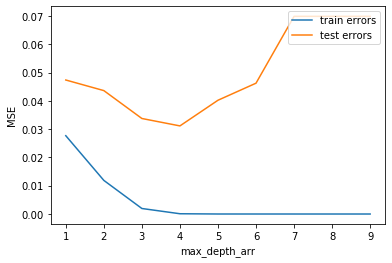

In [47]:
%%time

# etas = [0.5 + x*0.01 for x in range(1, 10)]
max_depth_arr = [x for x in range(1,10)]
MSEs_train = []
MSEs_test = []
eta = 0.2
n_trees = 15

for max_depth in max_depth_arr:
#     max_depth = 3

    trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

    train_prediction = gb_predict(X_train, trees, coefs, eta)
    MSEs_train.append(mean_squared_error(y_train, train_prediction))

    test_prediction = gb_predict(X_test, trees, coefs, eta)
    MSEs_test.append(mean_squared_error(y_test, test_prediction))

plt.plot(max_depth_arr, MSEs_train, label='train errors')
plt.plot(max_depth_arr, MSEs_test, label='test errors')
plt.xlabel('max_depth_arr')
plt.ylabel('MSE')
plt.legend(loc='upper right')                                   

In [55]:
%%time

# etas = [0.5 + x*0.01 for x in range(1, 10)]
max_depth_arr = [x for x in range(1,10)]
MSEs_train = []
MSEs_test = []
eta = 0.2
n_trees = 15
max_depth = 4
trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

train_prediction = gb_predict(X_train, trees, coefs, eta)
print(f'train - {mean_squared_error(y_train, train_prediction)}')

test_prediction = gb_predict(X_test, trees, coefs, eta)
print(f'test - {mean_squared_error(y_test, test_prediction)}')


train - 9.417998277873075e-05
test - 0.031147334053000353
Wall time: 4.43 s



Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.